In [40]:
import os
import numpy as np
import rasterio
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [42]:
# Normalization function
def normalize_data(images):
    for i in range(images.shape[1]):  # For each band
        band = images[:, i, :, :]
        min_val = np.min(band)
        max_val = np.max(band)
        images[:, i, :, :] = (band - min_val) / (max_val - min_val)
    return images

# Data loading function
def load_data(images_dir, labels_dir):
    images = []
    labels = []
    for i in tqdm(range(306), desc="Loading data"):
        img_path = os.path.join(images_dir, f"{i}.tif")
        label_path = os.path.join(labels_dir, f"{i}.png")
        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)
        label = np.array(Image.open(label_path)).astype(np.float32)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load and normalize data
images_dir = r"C:\Users\Lenovo\OneDrive - Alexandria University\Desktop\Projects\Water Segmentation\data-20240829T123932Z-001\data\images"
labels_dir = r"C:\Users\Lenovo\OneDrive - Alexandria University\Desktop\Projects\Water Segmentation\data-20240829T123932Z-001\data\labels"

X, y = load_data(images_dir, labels_dir)
X_normalized = normalize_data(X)

Loading data: 100%|█████████████████████████████████████████████████████████████████| 306/306 [00:02<00:00, 131.07it/s]


In [5]:

# Split the data into train, validation, and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Data shapes:
X_train: (183, 12, 128, 128)
y_train: (183, 128, 128)
X_val: (61, 12, 128, 128)
y_val: (61, 128, 128)
X_test: (62, 12, 128, 128)
y_test: (62, 128, 128)


In [7]:

# Save preprocessed data (optional)
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

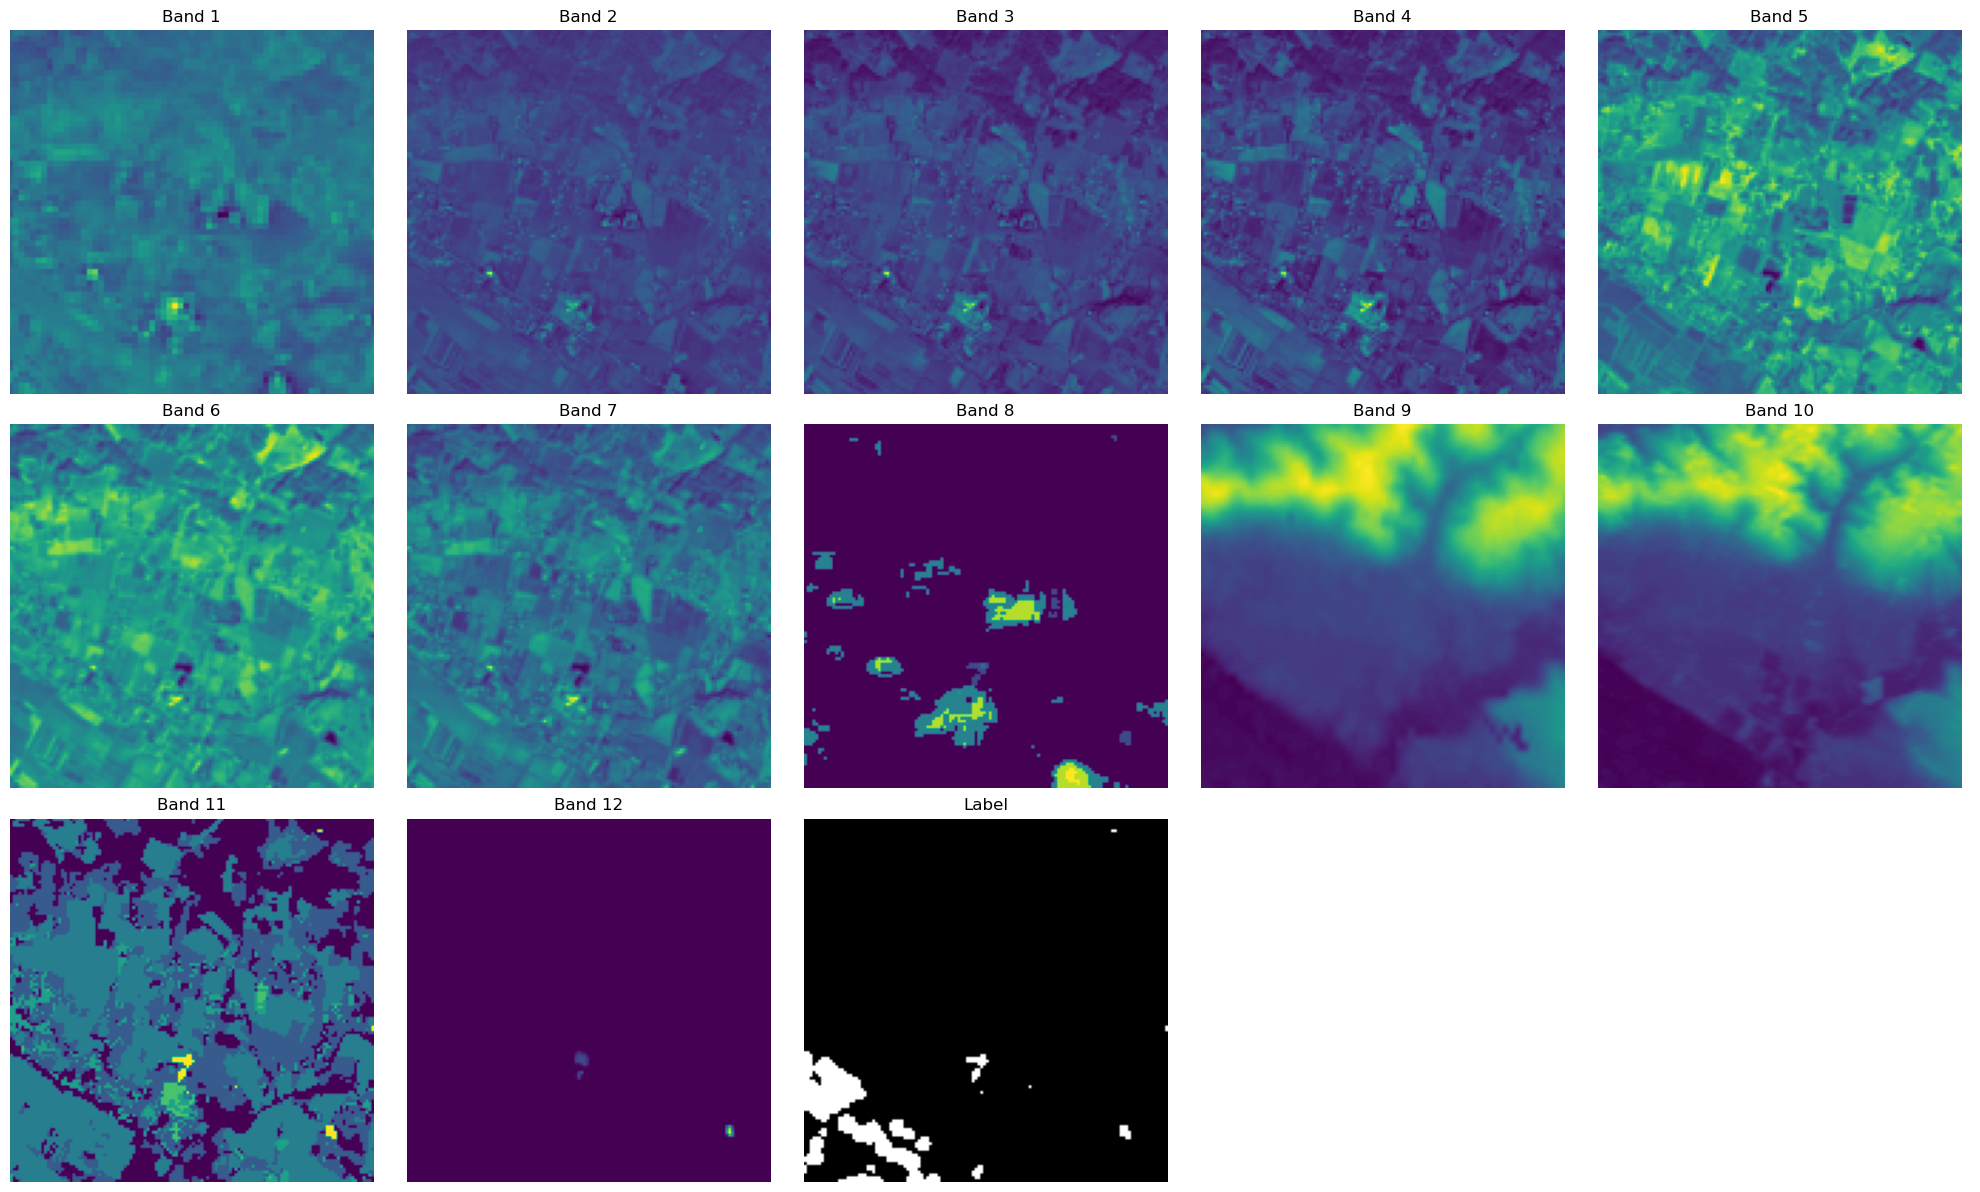

In [9]:
# Visualization function
def visualize_normalized_image(image, label):
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    for i, ax in enumerate(axes.flat):
        if i < 12:  # 12 bands
            ax.imshow(image[i], cmap='viridis')
            ax.set_title(f'Band {i+1}')
        elif i == 12:
            ax.imshow(label, cmap='gray')
            ax.set_title('Label')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the first image in the training set
visualize_normalized_image(X_train[5], y_train[5])

In [11]:
# Model definition (UNet)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(n_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bridge = DoubleConv(512, 1024)
        self.dec4 = DoubleConv(1024, 512)
        self.dec3 = DoubleConv(512, 256)
        self.dec2 = DoubleConv(256, 128)
        self.dec1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, n_classes, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bridge = self.bridge(self.pool(enc4))
        dec4 = self.dec4(torch.cat([self.up4(bridge), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.up3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1))
        return self.final(dec1)

# Custom Dataset
class WaterSegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float().unsqueeze(0)
        return image, mask

In [13]:
# Load preprocessed data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Set up datasets and dataloaders
train_dataset = WaterSegmentationDataset(X_train, y_train)
val_dataset = WaterSegmentationDataset(X_val, y_val)
test_dataset = WaterSegmentationDataset(X_test, y_test)

# Increase batch size to stabilize training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model, loss, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=12, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lowered learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)


C:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
# Function to calculate accuracy
def calculate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))
            predicted = (outputs > 0.5).float()
            correct += (predicted == masks).sum().item()
            total += masks.numel()
    return correct / total

# Training and validation with smoothed plots
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
ious = []

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validating"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_iou += iou_score(outputs, masks)
    return total_loss / len(loader), total_iou / len(loader)

def iou_score(preds, targets):
    preds = torch.sigmoid(preds) > 0.5  # Convert predictions to binary
    preds = preds.bool()  # Convert to boolean
    targets = targets.bool()  # Convert targets to boolean

    intersection = (preds & targets).float().sum((1, 2))
    union = (preds | targets).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


Epoch 1/50, Train Loss: 0.5422, Val Loss: 0.6940


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.17s/it]


Epoch 2/50, Train Loss: 0.4707, Val Loss: 0.6410


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.21s/it]


Epoch 3/50, Train Loss: 0.4385, Val Loss: 0.5607


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


Epoch 4/50, Train Loss: 0.4083, Val Loss: 0.4934


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


Epoch 5/50, Train Loss: 0.3971, Val Loss: 0.4430


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch 6/50, Train Loss: 0.3787, Val Loss: 0.4144


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 7/50, Train Loss: 0.3797, Val Loss: 0.3873


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]


Epoch 8/50, Train Loss: 0.3705, Val Loss: 0.3741


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


Epoch 9/50, Train Loss: 0.3580, Val Loss: 0.3660


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Epoch 10/50, Train Loss: 0.3544, Val Loss: 0.3593


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]


Epoch 11/50, Train Loss: 0.3425, Val Loss: 0.3272


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.44s/it]


Epoch 12/50, Train Loss: 0.3396, Val Loss: 0.3391


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


Epoch 13/50, Train Loss: 0.3326, Val Loss: 0.3324


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]


Epoch 14/50, Train Loss: 0.3287, Val Loss: 0.3818


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]


Epoch 15/50, Train Loss: 0.3196, Val Loss: 0.3521


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Epoch 16/50, Train Loss: 0.3202, Val Loss: 0.3188


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]


Epoch 17/50, Train Loss: 0.3110, Val Loss: 0.3152


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.43s/it]


Epoch 18/50, Train Loss: 0.3003, Val Loss: 0.3200


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 19/50, Train Loss: 0.2997, Val Loss: 0.3255


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.27s/it]


Epoch 20/50, Train Loss: 0.2940, Val Loss: 0.3515


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.35s/it]


Epoch 21/50, Train Loss: 0.2946, Val Loss: 0.3144


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 22/50, Train Loss: 0.2928, Val Loss: 0.3473


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]


Epoch 23/50, Train Loss: 0.2875, Val Loss: 0.3106


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


Epoch 24/50, Train Loss: 0.2774, Val Loss: 0.2960


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 25/50, Train Loss: 0.2685, Val Loss: 0.2916


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch 26/50, Train Loss: 0.2679, Val Loss: 0.2907


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch 27/50, Train Loss: 0.2623, Val Loss: 0.2832


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


Epoch 28/50, Train Loss: 0.2541, Val Loss: 0.2823


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


Epoch 29/50, Train Loss: 0.2523, Val Loss: 0.2882


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch 30/50, Train Loss: 0.2462, Val Loss: 0.2801


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


Epoch 31/50, Train Loss: 0.2391, Val Loss: 0.2775


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.26s/it]


Epoch 32/50, Train Loss: 0.2408, Val Loss: 0.2818


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


Epoch 33/50, Train Loss: 0.2392, Val Loss: 0.2758


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 34/50, Train Loss: 0.2349, Val Loss: 0.2831


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.31s/it]


Epoch 35/50, Train Loss: 0.2345, Val Loss: 0.2808


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]


Epoch 36/50, Train Loss: 0.2288, Val Loss: 0.2750


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 37/50, Train Loss: 0.2222, Val Loss: 0.2781


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.29s/it]


Epoch 38/50, Train Loss: 0.2222, Val Loss: 0.2694


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.24s/it]


Epoch 39/50, Train Loss: 0.2226, Val Loss: 0.2830


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 40/50, Train Loss: 0.2147, Val Loss: 0.2748


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


Epoch 41/50, Train Loss: 0.2128, Val Loss: 0.2609


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch 42/50, Train Loss: 0.2078, Val Loss: 0.2727


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


Epoch 43/50, Train Loss: 0.2053, Val Loss: 0.2724


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/it]


Epoch 44/50, Train Loss: 0.2020, Val Loss: 0.2610


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]


Epoch 45/50, Train Loss: 0.2039, Val Loss: 0.2564


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 46/50, Train Loss: 0.2029, Val Loss: 0.2734


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.36s/it]


Epoch 47/50, Train Loss: 0.1968, Val Loss: 0.2541


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]


Epoch 48/50, Train Loss: 0.1967, Val Loss: 0.2624


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch 49/50, Train Loss: 0.1923, Val Loss: 0.2556


Validating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]


Epoch 50/50, Train Loss: 0.1916, Val Loss: 0.2482


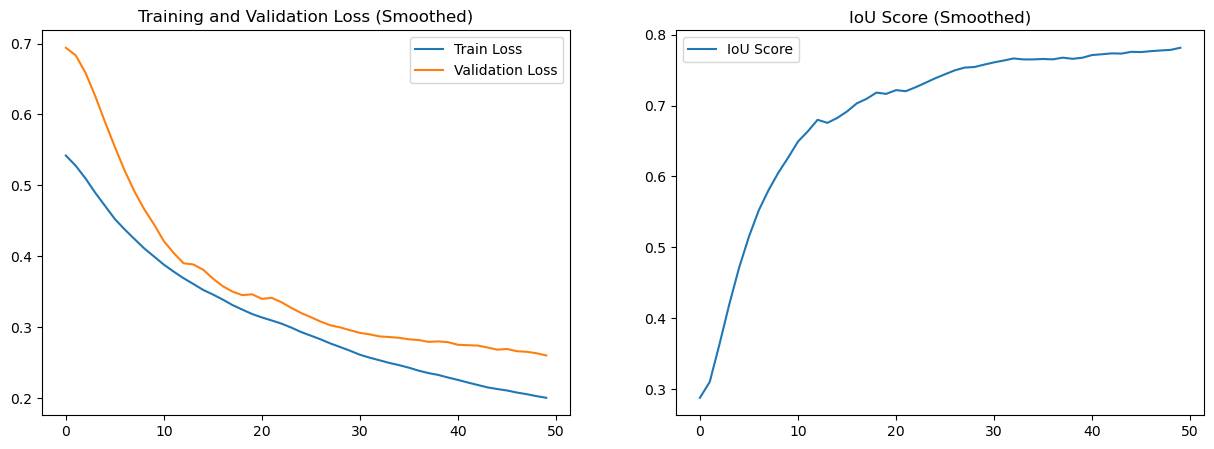

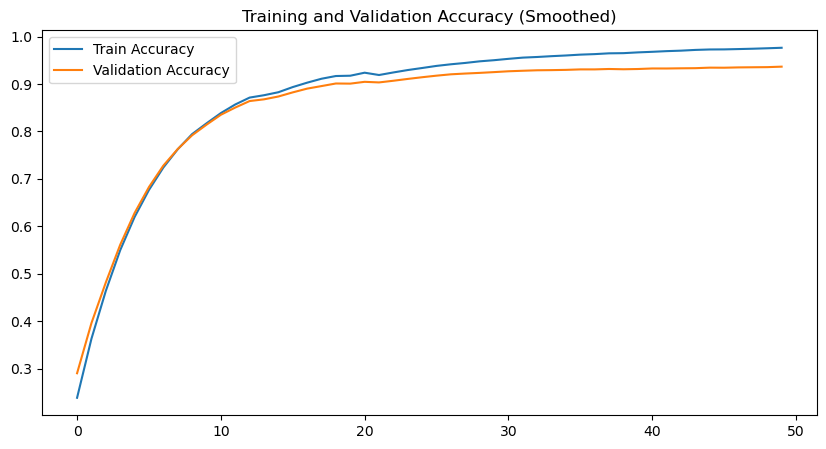

In [23]:
# Training loop
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    
    train_accuracy = calculate_accuracy(model, train_loader, device)
    val_accuracy = calculate_accuracy(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    ious.append(val_iou)
    
    # Custom print statement for progress
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')


# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the curves
smoothed_train_losses = smooth_curve(train_losses)
smoothed_val_losses = smooth_curve(val_losses)
smoothed_ious = smooth_curve(ious)
smoothed_train_accuracies = smooth_curve(train_accuracies)
smoothed_val_accuracies = smooth_curve(val_accuracies)

# Plot the smoothed training curves
plt.figure(figsize=(15, 5))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(smoothed_train_losses, label='Train Loss')
plt.plot(smoothed_val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Smoothed)')

# IoU Score
plt.subplot(1, 2, 2)
plt.plot(smoothed_ious, label='IoU Score')
plt.legend()
plt.title('IoU Score (Smoothed)')

plt.show()

# Plot the smoothed accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(smoothed_train_accuracies, label='Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Smoothed)')
plt.show()


In [24]:
# Evaluation on test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss = 0
test_iou = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        test_iou += iou_score(outputs, masks)
        
        preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
        all_preds.extend(preds.flatten())
        all_targets.extend(masks.cpu().numpy().flatten())

test_loss /= len(test_loader)
test_iou /= len(test_loader)

precision = precision_score(all_targets, all_preds, zero_division=1)
recall = recall_score(all_targets, all_preds, zero_division=1)
f1 = f1_score(all_targets, all_preds, zero_division=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3092\2264074610.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Testing:

Test Loss: 0.2168
Test IoU: 0.8011
Precision: 0.9362
Recall: 0.9047
F1 Score: 0.9202


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3092\3795540022.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_locat

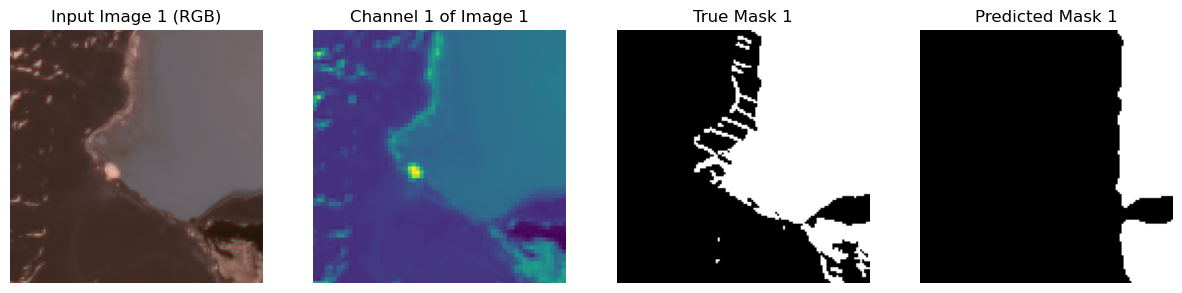

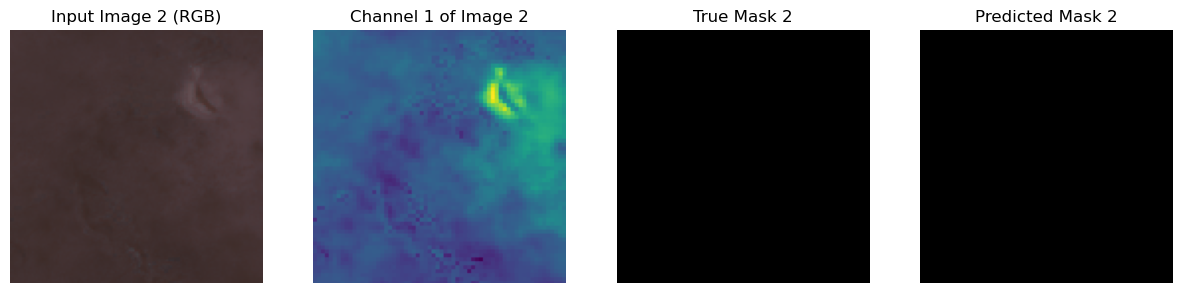

In [38]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth', map_location=device))

model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        if idx >= 5:  # We now want to test 5 images
            break
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        output = (torch.sigmoid(outputs[0]) > 0.5).float().cpu().numpy()
        image = images[0].cpu().numpy()
        mask = masks[0].cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(141)
        plt.imshow(np.moveaxis(image[:3], 0, -1))  # Visualizing the first three channels as RGB
        plt.title(f'Input Image {idx+1} (RGB)')
        plt.axis('off')

        plt.subplot(142)
        plt.imshow(image[0], cmap='viridis')  # Visualizing the first channel
        plt.title(f'Channel 1 of Image {idx+1}')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(mask[0], cmap='gray')
        plt.title(f'True Mask {idx+1}')
        plt.axis('off')

        plt.subplot(144)
        plt.imshow(output[0], cmap='gray')
        plt.title(f'Predicted Mask {idx+1}')
        plt.axis('off')

        plt.show()

In [44]:
# Save the trained model's state_dict
torch.save(model.state_dict(), 'best_model.pth')